In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import os

# Imports for visualizations
import shap as shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [31]:
# Specify the path to your model and the data directories and parameters

MODEL_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/computed_data/2025_07_10_plant_classifier_fine_tuned.keras"
TRAIN_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/original_data/2.1.1 New Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
VALID_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/original_data/2.1.1 New Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [32]:
# Load training data from the 'train' directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    shuffle=True, 
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Load validation data from the 'valid' directory
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    shuffle=False, 
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Get class names from the dataset object
class_names = train_dataset.class_names
num_classes = len(class_names)
print("Found classes:", class_names)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Found classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold'

In [116]:
# Load the pre-trained model
model = tf.keras.models.load_model(MODEL_DIR 
,custom_objects={'preprocess_input': preprocess_input})

# Display the model architecture
model.summary()  # Verify this matches your expectations

# Check input shape compatibility
print(f"Model input shape: {model.input_shape}")
print(f"Number of classes: {num_classes}")  # Should be 38


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,126,900 (23.37 MB)

 Trainable params: 1,910,118 (7.29 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 3,820,238 (14.57 MB)

Model input shape: (None, 224, 224, 3)
Number of classes: 38


In [68]:
# Print all layer names to identify the correct one for Grad-CAM
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} ({layer.__class__.__name__})")

# For MobileNetV2, we typically want the last convolutional layer before the top layers
# This is usually within the MobileNetV2 base model
mobilenet_layers = model.get_layer('mobilenetv2_1.00_224').layers
for i, layer in enumerate(mobilenet_layers):
    if 'Conv' in layer.__class__.__name__:
        print(f"{i}: {layer.name} ({layer.__class__.__name__})")

0: input_layer_1 (InputLayer)
1: sequential (Sequential)
2: mobilenetv2_1.00_224 (Functional)
3: global_average_pooling2d (GlobalAveragePooling2D)
4: dropout (Dropout)
5: dense (Dense)
1: Conv1 (Conv2D)
4: expanded_conv_depthwise (DepthwiseConv2D)
7: expanded_conv_project (Conv2D)
9: block_1_expand (Conv2D)
13: block_1_depthwise (DepthwiseConv2D)
16: block_1_project (Conv2D)
18: block_2_expand (Conv2D)
21: block_2_depthwise (DepthwiseConv2D)
24: block_2_project (Conv2D)
27: block_3_expand (Conv2D)
31: block_3_depthwise (DepthwiseConv2D)
34: block_3_project (Conv2D)
36: block_4_expand (Conv2D)
39: block_4_depthwise (DepthwiseConv2D)
42: block_4_project (Conv2D)
45: block_5_expand (Conv2D)
48: block_5_depthwise (DepthwiseConv2D)
51: block_5_project (Conv2D)
54: block_6_expand (Conv2D)
58: block_6_depthwise (DepthwiseConv2D)
61: block_6_project (Conv2D)
63: block_7_expand (Conv2D)
66: block_7_depthwise (DepthwiseConv2D)
69: block_7_project (Conv2D)
72: block_8_expand (Conv2D)
75: block_8_

In [114]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,126,900 (23.37 MB)

 Trainable params: 1,910,118 (7.29 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 3,820,238 (14.57 MB)

In [77]:
# Print all layer names to identify the correct one for Grad-CAM
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} ({layer.__class__.__name__})")

# For MobileNetV2, we typically want the last convolutional layer before the top layers
# This is usually within the MobileNetV2 base model
mobilenet_layers = model.get_layer('mobilenetv2_1.00_224').layers
for i, layer in enumerate(mobilenet_layers):
    if 'Conv' in layer.__class__.__name__:
        print(f"{i}: {layer.name} ({layer.__class__.__name__})")

0: input_layer_1 (InputLayer)
1: sequential (Sequential)
2: mobilenetv2_1.00_224 (Functional)
3: global_average_pooling2d (GlobalAveragePooling2D)
4: dropout (Dropout)
5: dense (Dense)
1: Conv1 (Conv2D)
4: expanded_conv_depthwise (DepthwiseConv2D)
7: expanded_conv_project (Conv2D)
9: block_1_expand (Conv2D)
13: block_1_depthwise (DepthwiseConv2D)
16: block_1_project (Conv2D)
18: block_2_expand (Conv2D)
21: block_2_depthwise (DepthwiseConv2D)
24: block_2_project (Conv2D)
27: block_3_expand (Conv2D)
31: block_3_depthwise (DepthwiseConv2D)
34: block_3_project (Conv2D)
36: block_4_expand (Conv2D)
39: block_4_depthwise (DepthwiseConv2D)
42: block_4_project (Conv2D)
45: block_5_expand (Conv2D)
48: block_5_depthwise (DepthwiseConv2D)
51: block_5_project (Conv2D)
54: block_6_expand (Conv2D)
58: block_6_depthwise (DepthwiseConv2D)
61: block_6_project (Conv2D)
63: block_7_expand (Conv2D)
66: block_7_depthwise (DepthwiseConv2D)
69: block_7_project (Conv2D)
72: block_8_expand (Conv2D)
75: block_8_

In [117]:
#Grad-CAM: Visualizing Decisions

#Selection 4 images from the validation dataset
X = np.array([img.numpy() for img, _ in validation_dataset.take(2)][0]).astype(np.uint8)
y = np.array([label.numpy() for _, label in validation_dataset.take(2)][0])

# Select specific images
images = X[:4]
labels = y[:4]

In [118]:
def grad_cam(image, model, layer_name):
    # Retrieve the convolutional layer
    layer = model.get_layer(layer_name)
    
    # Create a model that generates the outputs of the convolutional layer and the predictions
    grad_model = Model(inputs=model.input, outputs=[layer.output, model.output])

    # Add a batch dimension
    image = tf.expand_dims(image, axis=0)

    # Compute the gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        predicted_class = tf.argmax(predictions[0])  # Predicted class
        loss = predictions[:, predicted_class]  # Loss for the predicted class

    # Gradients of the scores with respect to the outputs of the convolutional layer
    grads = tape.gradient(loss, conv_outputs)

    # Weighted average of the gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the activations by the calculated gradients
    conv_outputs = conv_outputs[0]  # Remove the batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0)  # Focus only on positive values
    heatmap /= tf.math.reduce_max(heatmap)  # Normalize between 0 and 1
    heatmap = heatmap.numpy()  # Convert to numpy array for visualization

    # Resize the heatmap to match the original image size
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (image.shape[1], image.shape[2])).numpy()
    heatmap_resized = np.squeeze(heatmap_resized, axis=-1)  # Remove the singleton dimension at the end of the heatmap_resized array

    # Color the heatmap with a palette (e.g., "jet")
    heatmap_colored = plt.cm.jet(heatmap_resized)[..., :3]  # Get the R, G, B channels 

    superimposed_image = heatmap_colored * 0.7 + image[0].numpy() / 255.0

    return np.clip(superimposed_image, 0, 1), predicted_class

In [119]:
def show_grad_cam_cnn(images, model):
    number_of_images = images.shape[0]
    conv_layers = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]

    plt.figure(figsize=(16,16))

    for j, layer in enumerate(conv_layers):

        for i in range(number_of_images):

            subplot_index = i + 1 + j * number_of_images
            plt.subplot(len(conv_layers), number_of_images, subplot_index)

            # Get the image with the overlaid heatmap
            grad_cam_image, predicted_class = grad_cam(images[i], model, layer)
            
            # Display the image with Grad-CAM
            plt.title(f'Grad-CAM {layer}')
            plt.imshow(grad_cam_image)
            plt.axis("off")

    plt.show()

show_grad_cam_cnn(images, model)

NameError: name 'Conv2D' is not defined

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 3/4 [00:20<00:05,  5.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [00:30<00:00,  7.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [00:41, 10.27s/it]                       


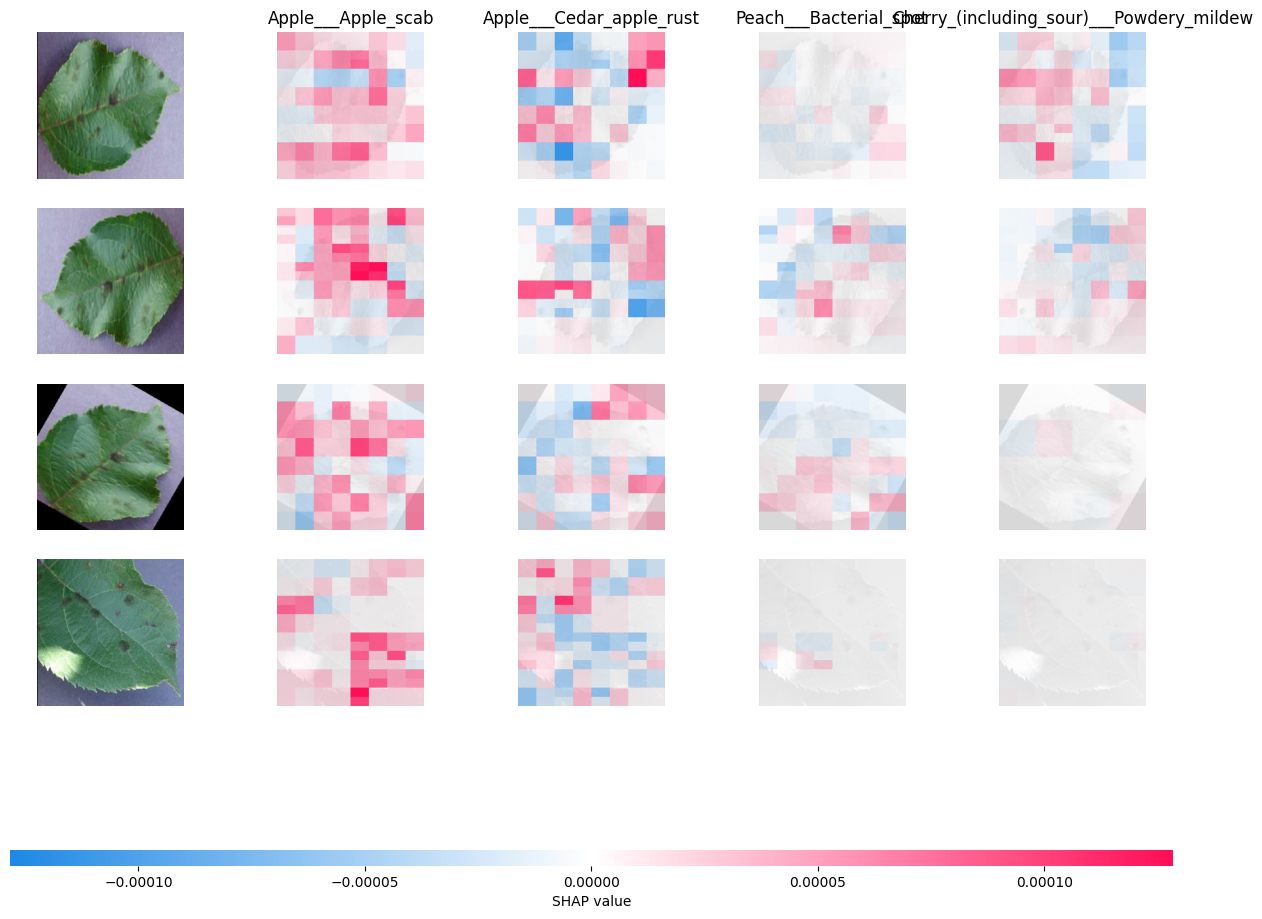

In [120]:
#Shap
import shap
masker = shap.maskers.Image("inpaint_telea", images[0].shape) # inpaint_telea blurs the image regions to explain 

explainer = shap.Explainer(model, masker, output_names=class_names)

shap_values = explainer(images, 
                        max_evals=500,  
                        outputs=shap.Explanation.argsort.flip[:4])

shap.image_plot(shap_values)
